In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

In [2]:
train = torch.load('torch/train.pt')
train_loader = DataLoader(train, batch_size=1)
val = torch.load('torch/val.pt')
val_loader = DataLoader(val, batch_size=1)
test = torch.load('torch/test.pt')
test_loader = DataLoader(test, batch_size=1)

In [3]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 1, kernel_size=1, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

model = SegmentationModel()

In [4]:
lr = 0.001
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SegmentationModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)

In [5]:
def accuracy(outputs, labels, threshold=0.5):
    preds = torch.sigmoid(outputs) > threshold 
    correct = (preds == labels).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy.item()

In [6]:
def evaluate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.float().to(device), labels.float().to(device)
            labels = labels.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += accuracy(outputs, labels)
    return val_loss / len(val_loader), val_accuracy / len(val_loader)

In [7]:
def train_model(model, train_loader, val_loader, lr, num_epochs, device):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        for images, labels in train_loader:
            images, labels = images.float().to(device), labels.float().to(device)
            labels = labels.unsqueeze(1)  # add channel dim

            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_accuracy += accuracy(outputs, labels)
        
        val_loss, val_accuracy = evaluate(model, criterion, val_loader, device)
        
        print(f"""Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss/len(train_loader)}, Training Accuracy: {epoch_accuracy/len(train_loader)}, 
              Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}""")



In [14]:
def test_model(model, test_loader, device, num_images=5, plot=True):
    model.eval()
    criterion = nn.BCEWithLogitsLoss()
    test_loss = 0
    test_accuracy = 0
    images_list, labels_list, preds_list = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.float().to(device), labels.float().to(device)
            labels = labels.unsqueeze(1)  
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_accuracy += accuracy(outputs, labels)
            
            preds = torch.sigmoid(outputs) > 0.5 
            
            images_list.append(images.cpu())
            labels_list.append(labels.cpu())
            preds_list.append(preds.cpu())
            
            if len(images_list) * images.size(0) >= num_images:
                break
    
    avg_test_loss = test_loss / len(test_loader)
    avg_test_accuracy = test_accuracy / len(test_loader)
    
    print(f"Test Loss: {avg_test_loss}, Test Accuracy: {avg_test_accuracy}")
    
    if plot:
        images_list = torch.cat(images_list)[:num_images]
        labels_list = torch.cat(labels_list)[:num_images]
        preds_list = torch.cat(preds_list)[:num_images]
        plot_results(num_images, images_list, labels_list, preds_list)

In [15]:
def plot_results(num_images, images_list, labels_list, preds_list):
    n = len(images_list)

    _, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        img = images_list[i].permute(1, 2, 0) 
        label = labels_list[i].squeeze(0)
        pred = preds_list[i].squeeze(0)

        if num_images == 1:
            axes[0].imshow(img.numpy())
            axes[0].set_title('Image')
            axes[1].imshow(label.numpy(), cmap='gray')
            axes[1].set_title('Ground Truth')
            axes[2].imshow(pred.numpy(), cmap='gray')
            axes[2].set_title('Prediction')
        else:
            axes[i, 0].imshow(img.numpy())
            axes[i, 0].set_title('Image')
            axes[i, 1].imshow(label.numpy(), cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 2].imshow(pred.numpy(), cmap='gray')
            axes[i, 2].set_title('Prediction')
    
    plt.tight_layout()
    plt.show()

In [10]:
train_model(model, train_loader, val_loader, lr, num_epochs, device)

Epoch 1/10, Training Loss: 0.18021729141996978, Training Accuracy: 0.9451697315170227, 
              Validation Loss: 0.15597327121990484, Validation Accuracy: 0.9461794683116233
Epoch 2/10, Training Loss: 0.1522531750273391, Training Accuracy: 0.9465354848130841, 
              Validation Loss: 0.13640068437624045, Validation Accuracy: 0.9462205661322646
Epoch 3/10, Training Loss: 0.13924741135339083, Training Accuracy: 0.9487206900867824, 
              Validation Loss: 0.1305317846205884, Validation Accuracy: 0.9496982245741483
Epoch 4/10, Training Loss: 0.1330756782441405, Training Accuracy: 0.9506653402453271, 
              Validation Loss: 0.12561809049709804, Validation Accuracy: 0.951434118236473
Epoch 5/10, Training Loss: 0.1298459533240074, Training Accuracy: 0.95141047438251, 
              Validation Loss: 0.12269938861805085, Validation Accuracy: 0.9525124467685371
Epoch 6/10, Training Loss: 0.12825894461760173, Training Accuracy: 0.9518596409796395, 
              Valid

In [11]:
bologna = torch.load('torch/bologna.pt')
bologna_loader = DataLoader(bologna, batch_size=1)

Test Loss: 0.11376650631427765, Test Accuracy: 0.9556413292884827


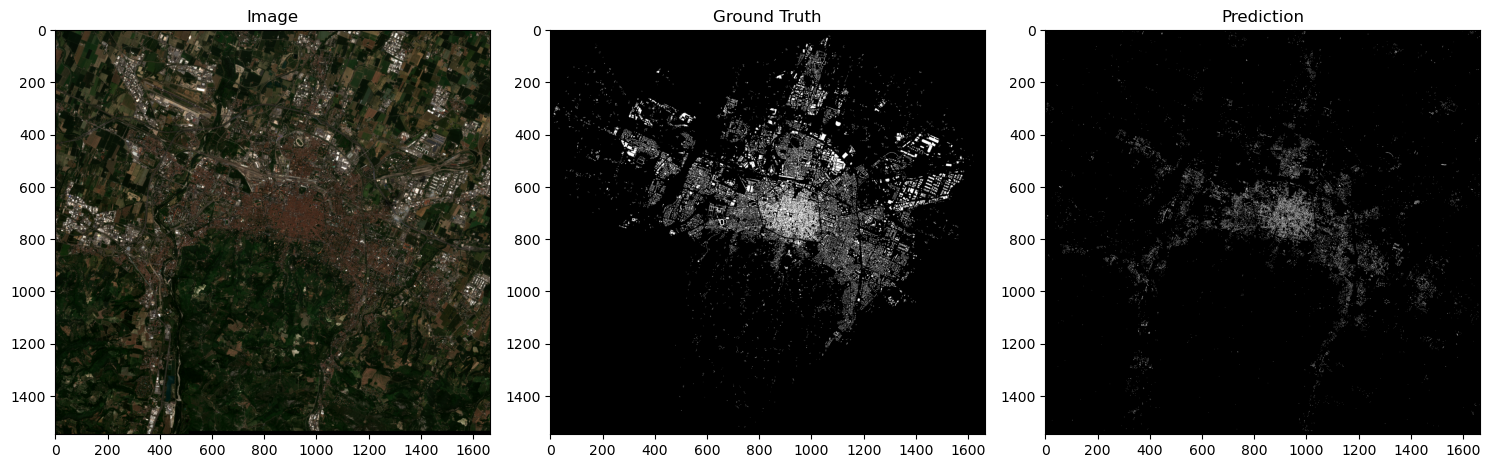

In [16]:
test_model(model, bologna_loader, device, num_images=1, plot=True)

Test Loss: 0.0011036577415213975, Test Accuracy: 0.009566007014028056


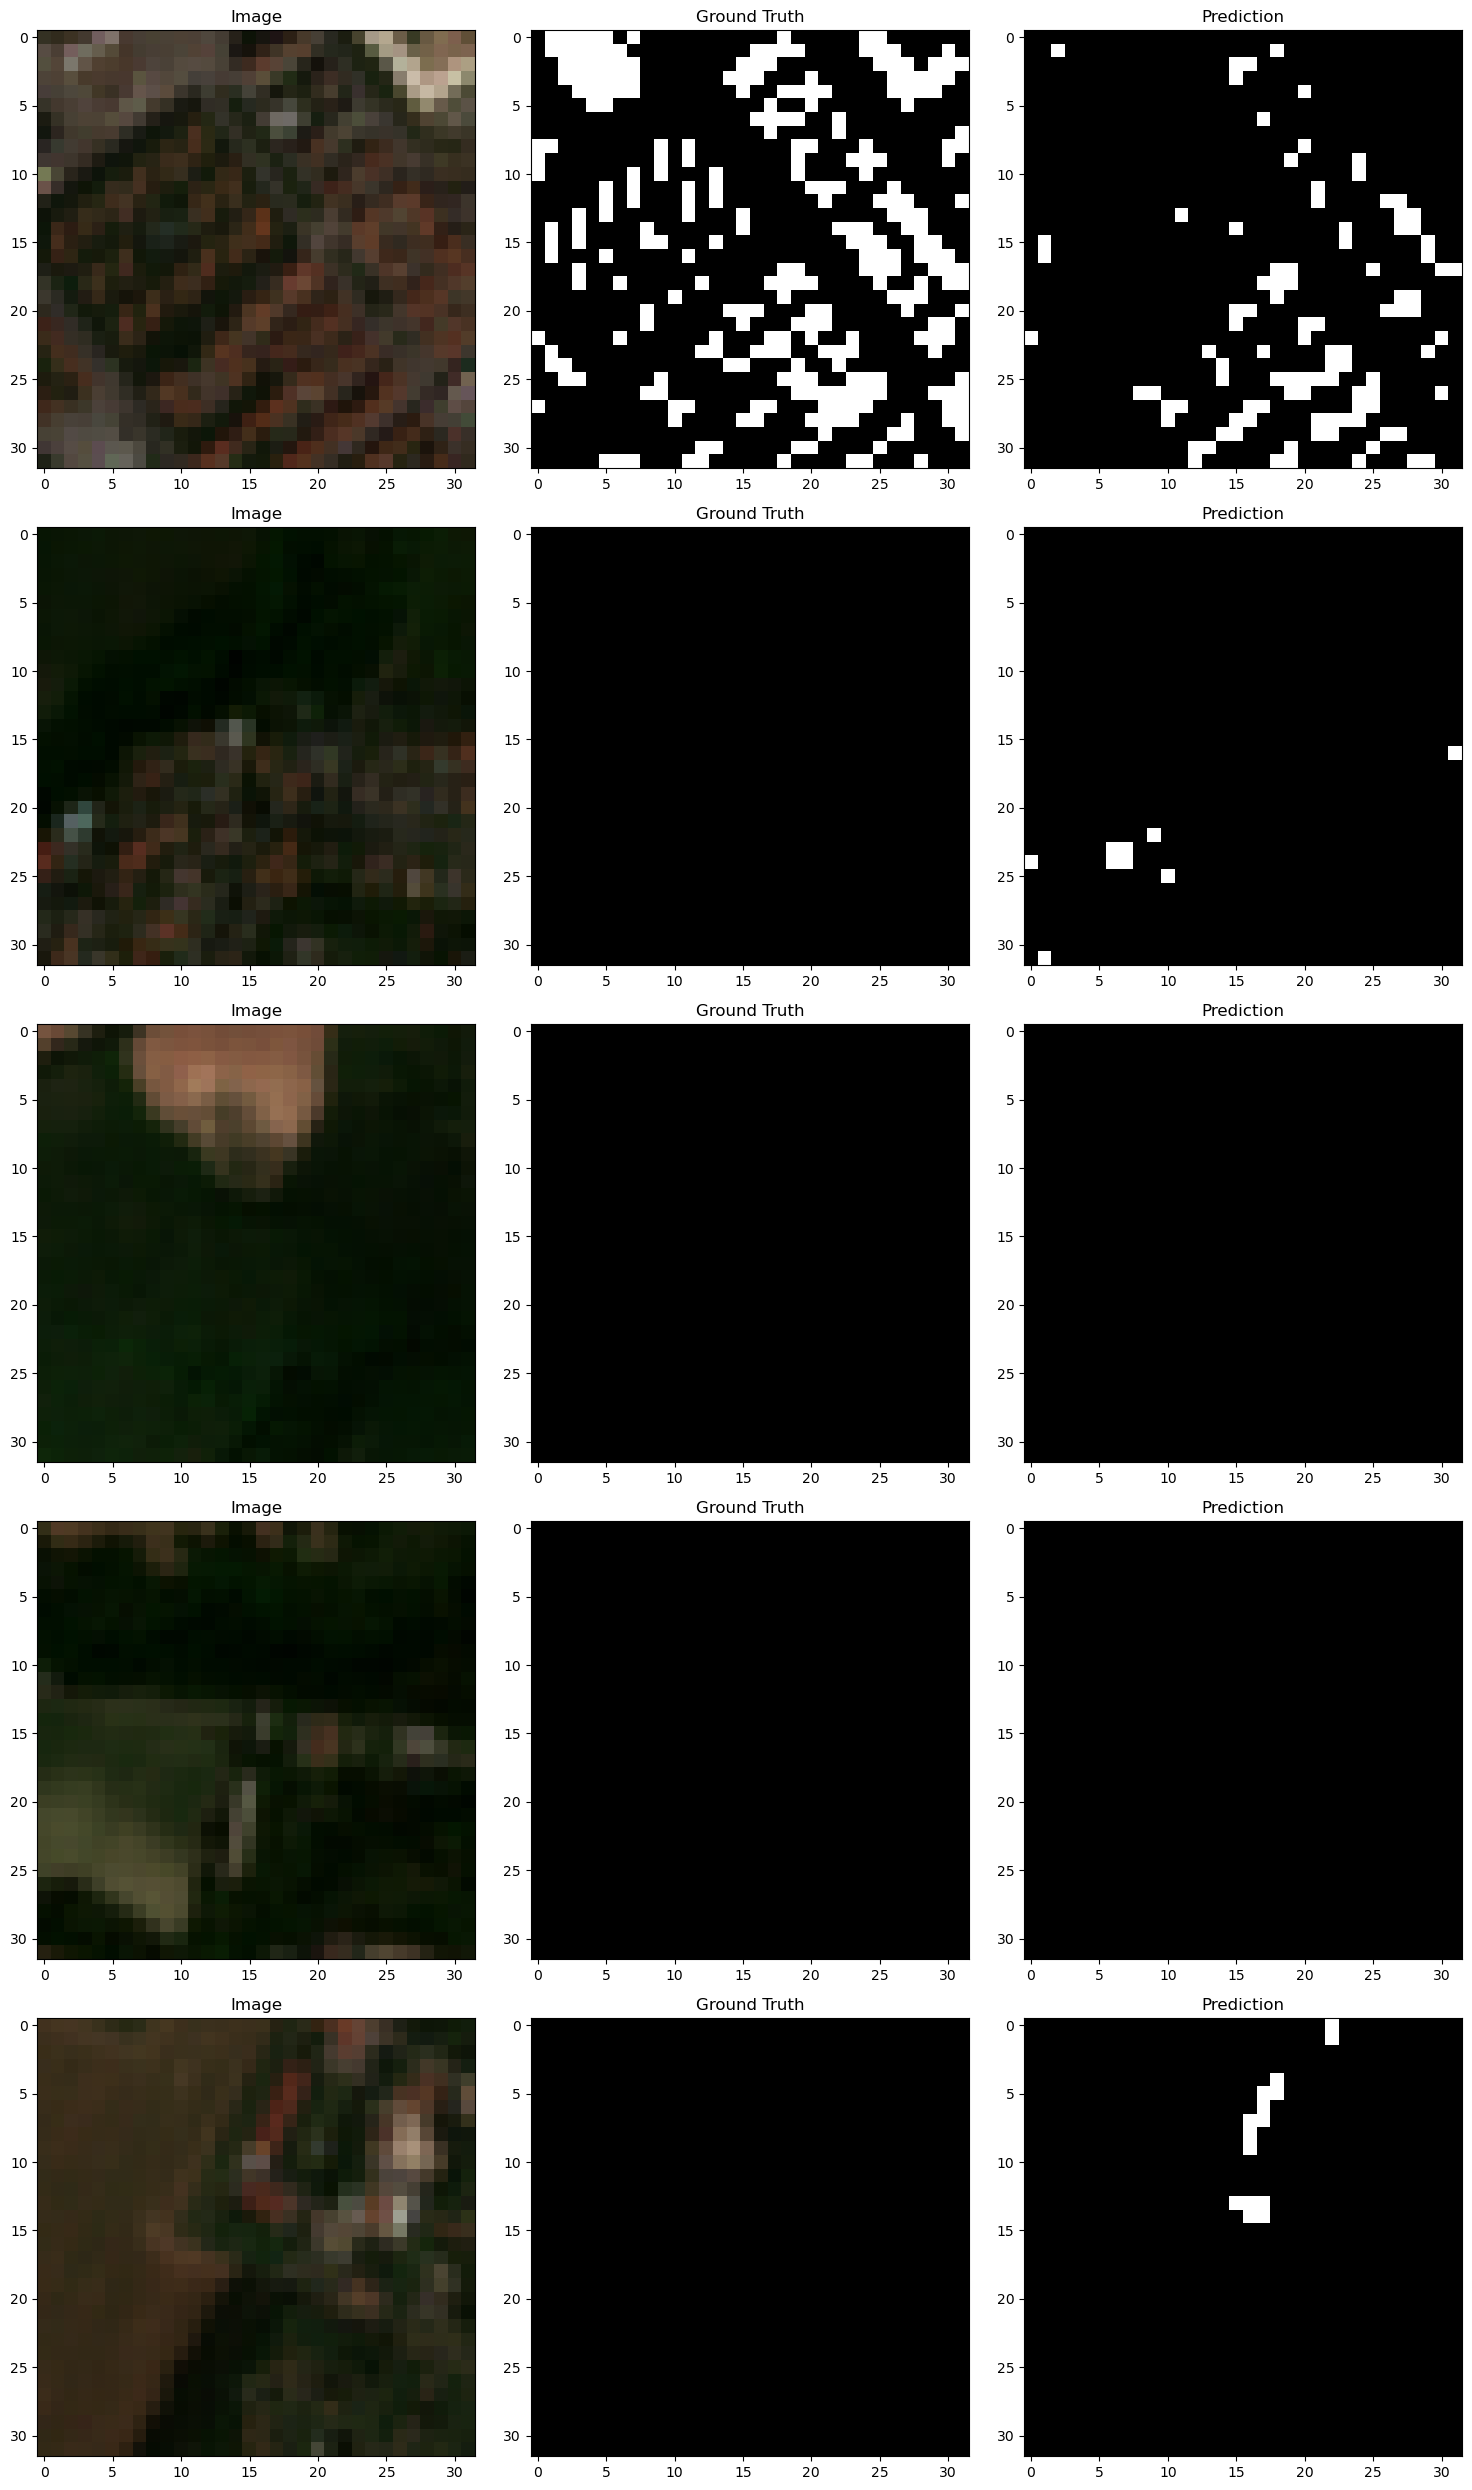

In [17]:
test_model(model, test_loader, device, num_images=5)